# GPR
 * Implement multiple kernels
     * linear
     * periodic
 * Use HXDY to do log marginal likelihood optimization
#### Imports and Function Defs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import scipy.sparse.linalg

### Kernel Defs

In [2]:
#@nb.njit(cache=True)
def rbf(xp, xq, sf, l):
    return sf*sf*np.exp(-.5 * np.power((xp-xq)/l, 2))

In [3]:
np.vectorize
def periodic(xp, xq, sf, p, l, mu):
    return sf*sf*np.exp(-2.*np.power(np.sin(np.pi*(xp-xq)/p - mu)/l,2))

In [4]:
def kernel(xp, xq, params):
    return rbf(xp, xq, params[0], params[1]) + \
        periodic(xp, xq, params[2], params[3], params[4], params[5])

### Kernel Derivative Defs

In [5]:
#@nb.njit(cache=True)
def rbf_prime(xp, xq, sf, l):
    x_diff = xp-xq # this is a vector
    result = np.empty(2)

    result[0] = 2.*sf*np.exp(-.5 * np.power(x_diff/l, 2))
    
    result[1] = sf*sf*np.exp(-.5 * np.power(x_diff/l, 2)) * x_diff * x_diff * np.power(l, -3)
    
    return result

In [6]:
def periodic_prime(xp, xq, sf, p, l, mu):
    result = np.empty(4)
    sin_arg = mu + np.pi*(-xp+xq)/p
    exp_arg = -2*np.power(np.sin(sin_arg)/l, 2)
    
    # derivative w.r.t. sf
    result[0] = 2.*sf*exp_arg
    # derivative w.r.t. p
    result[1] = 2*exp_arg*np.pi*sf*sf*(-xp+xq)*np.sin(2*sin_arg)*np.power(l*p,-2)
    # derivative w.r.t. l
    result[2] = 4*exp_arg*sf*sf*np.sin(sin_arg)*np.power(l,-3)
    
    # derivative w.r.t. mu
    result[3] = -2*exp_arg*sf*sf*np.sin(2*sin_arg)*np.power(l,-2)
    
    return result

In [7]:
def kernel_prime(xp, xq, params):
    return np.append(rbf_prime(xp, xq, params[0], params[1]),
        periodic_prime(xp, xq, params[2], params[3], params[4], params[5]))

### Covariance Matrix Calculations

In [8]:
#@nb.njit(cache=True)
def K_XX(X, params):
    cov = np.empty((len(X),len(X)))
    for i in range(len(X)):
        for j in range(i+1):
            cov[i,j] = cov[j,i] = kernel(X[i], X[j], params)
    return cov

In [9]:
#@nb.njit(cache=True)
def K_XY(X, Y, params):
    cov = np.empty((len(Y),len(X)))
    for i in range(len(Y)):
        for j in range(len(X)):
            cov[i,j] = kernel(Y[i], X[j], params)
    return cov

### Prediction Tools

In [10]:
#@nb.njit(cache=True)
def predict(X, X_s, params, k_xx_i_y, y_mean):
    return np.dot(K_XY(X, X_s, params), k_xx_i_y) + y_mean

In [11]:
def fitPredict(X_train, y_train, X_test, params):

    k_xx = K_XX(X_train, params)
    y_mean = np.mean(y_train)
    k_xx_i_y = scipy.sparse.linalg.minres(k_xx, y_train-y_mean)[0] 
    pred = predict(X_train, X_test, params, k_xx_i_y, y_mean)
    
    return pred

### $\theta$ Optimization Tools

In [12]:
#@nb.njit(cache=True)
def log_marginal_likelihood(x, y, params):
    K = K_XX(x, params)
    K_inv = np.linalg.pinv(K)
    
    term1 = -.5*np.log(np.linalg.det(K))
    term2 = -.5*((y.T @ K_inv @ y))
    term3 = -(len(x)/2)*np.log(2.*np.pi)
    return -(term1 + term2 + term3)

In [13]:
def log_marginal_likelihood_prime(x, y, params):
    
    K = K_XX(x, params)
    K_inv = np.linalg.pinv(K)

    alpha = y.T @ K_inv

    kernel_der = np.empty((len(x), len(x), len(params)))

    for i in range(len(x)):
        for j in range(len(x)):
            kernel_der[i,j] = kernel_prime(x[i], x[j], params)
    #print('kernel_der', kernel_der.shape)
    #print(np.around(kernel_der[:,:,0], 2))
    
    der = np.empty(len(params))
    
    for i in range(len(der)):
        idx = tuple([slice(None)]*(kernel_der.ndim-1) + [i])
        #print(np.around(kernel_der[idx], 2))
        der[i] = (.5 * alpha @ kernel_der[idx] @ alpha.T)
        der[i] -= .5*np.trace(K_inv @ kernel_der[idx])
        #print((.5 * alpha @ kernel_der[idx] @ alpha.T)[0,0], -.5*np.trace(K_inv @ kernel_der[idx]))
    return -der

### Testing

In [14]:
n = 300

In [15]:
x = np.arange(0, np.pi, 1e-3)
y = np.sin(x*np.pi) #+ .01*np.random.normal(size=len(x))

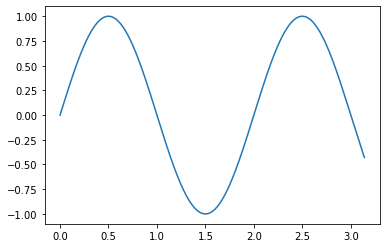

In [16]:
plt.plot(x, y)

In [51]:
# sf, p, l, mu
params = np.array([0., 1, 1., 2, 10, np.pi/4])

In [52]:
func_wrapper(params, x[::n], y[::n])

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


(-inf, array([-0.        , -0.        , -0.00968906,  0.08543339,  0.18091834,
        -0.04741994]))

In [18]:
p = fitPredict(x[::n], y[::n], x, params)

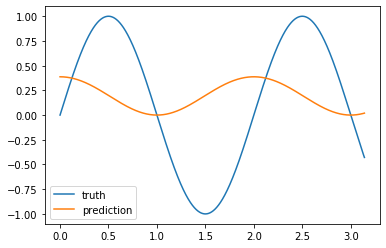

In [19]:
plt.plot(x, y, label='truth')
plt.plot(x, p, label='prediction');
plt.legend();

In [48]:
# sf, p, l, mu
params = np.array([0., 1, 1., 2, 10, 0])

In [40]:
p = fitPredict(x[::n], y[::n], x, params)

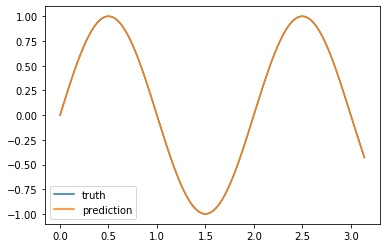

In [41]:
plt.plot(x, y, label='truth')
plt.plot(x, p, label='prediction');
plt.legend();

In [42]:
import scipy.optimize

In [43]:
def func_wrapper(p, x, y):
    return log_marginal_likelihood(x, y, p), log_marginal_likelihood_prime(x, y, p)

In [44]:
best = scipy.optimize.minimize(func_wrapper, x0=params, args=(x[::n], y[::n]), jac=True, method='BFGS')
best

      fun: -18.69490548051146
 hess_inv: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         2.32377100e-12,  8.45908722e-10,  1.01854013e-19],
       [ 0.00000000e+00,  0.00000000e+00,  2.32377100e-12,
         1.00000000e+00,  4.22452055e-09,  1.19749109e-21],
       [ 0.00000000e+00,  0.00000000e+00,  8.45908722e-10,
         4.22452055e-09,  2.67308015e-15, -1.08241515e-14],
       [ 0.00000000e+00,  0.00000000e+00,  1.01854013e-19,
         1.19749109e-21, -1.08241515e-14,  1.00000000e+00]])
      jac: array([-0.00000000e+00, -0.00000000e+00, -1.00012094e+02, -1.15607961e+00,
        4.42859702e+05, -4.47581174e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 47
      nit: 1
     njev: 36


In [45]:
p = fitPredict(x[::n], y[::n], x, best.x)

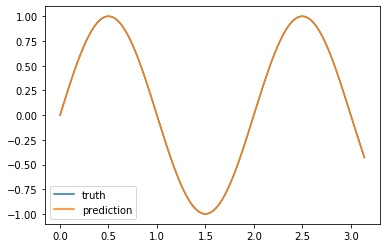

In [46]:
plt.plot(x, y, label='truth')
plt.plot(x, p, label='prediction');
plt.legend();

In [47]:
# sf, p, l, mu
params = np.array([0., 1, 1., 1.8, 1, 0])

In [30]:
p = fitPredict(x[::n], y[::n], x, params)

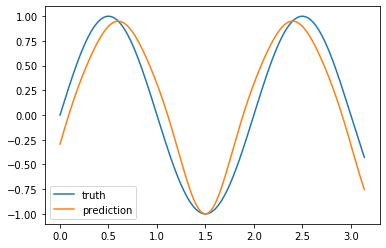

In [31]:
plt.plot(x, y, label='truth')
plt.plot(x, p, label='prediction');
plt.legend();

In [50]:
func_wrapper(params, x[::n], y[::n])

(-18.69384133615815,
 array([-0.00000000e+00, -0.00000000e+00, -1.00005819e+02, -1.12474543e+00,
        -6.97435712e+06, -1.25043196e-07]))